<a href="https://colab.research.google.com/github/fdebrain/kaggle-odometer-mileage-detection/blob/main/Kaggle_Odometer_Mileage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Copy compressed dataset from Drive and unzip
!cp ./drive/My\ Drive/acedatathon19-odometer.zip /content
!unzip acedatathon19-odometer.zip

Archive:  acedatathon19-odometer.zip
replace getting_started.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: ywa
  inflating: getting_started.ipynb   
replace sample_solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: sample_solution.csv     
  inflating: test/test/3634/0.png    
  inflating: test/test/3634/1.png    
  inflating: test/test/3634/2.png    
  inflating: test/test/3634/3.png    
  inflating: test/test/3634/4.png    
  inflating: test/test/3635/0.png    
  inflating: test/test/3635/1.png    
  inflating: test/test/3635/2.png    
  inflating: test/test/3635/3.png    
  inflating: test/test/3635/4.png    
  inflating: test/test/3636/0.png    
  inflating: test/test/3636/1.png    
  inflating: test/test/3636/2.png    
  inflating: test/test/3636/3.png    
  inflating: test/test/3636/4.png    
  inflating: test/test/3637/0.png    
  inflating: test/test/3637/1.png    
  inflating: test/test/3637/2.png    
  inflating: test/test/3637/3.png    
  inflating: test/tes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
import torch
from torch import nn, optim
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchvision import transforms, utils
from tqdm.autonotebook import tqdm
from itertools import count
import time

# Visualize dataset

Train images: 3633
Test images: 0


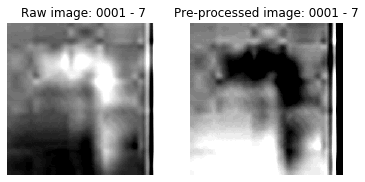

In [ ]:
%matplotlib inline

# Import train and test sets
train_image_folders = sorted(glob.glob("train/train/*"))
test_image_folders = sorted(glob.glob("test/test/*"))
print('Train images: {}'.format(len(train_image_folders)))
print('Test images: {}'.format(len(test_image_folders)))

# Import labels
train_labels = pd.read_csv('train_labels.csv', index_col=False, dtype=object)
train_labels.head()

# Sequence paths
train_image_folders = sorted(glob.glob("train/train/*"))
test_image_folders = sorted(glob.glob("test/test/*"))

# Sequence idx -> digit idx
seq_idx = 0
digit_idx = 0

# Load corresponding image and label
img_path = sorted(glob.glob(train_image_folders[seq_idx] + '/*'))[digit_idx]

# Visualize digit
fig, ax = plt.subplots(1,2)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
ax[0].imshow(img, cmap='gray')
ax[0].set_title(f"Raw image: {train_labels['Image'].iloc[seq_idx]} - {train_labels['Label'].iloc[seq_idx][digit_idx]}")
ax[0].axis('off')

# Apply preprocessing
img_preprocessed = preprocess(img)
ax[1].imshow(img_preprocessed, cmap='gray')
ax[1].set_title(f"Pre-processed image: {train_labels['Image'].iloc[seq_idx]} - {train_labels['Label'].iloc[seq_idx][digit_idx]}")
ax[1].axis('off');

# Pipeline

## Load data

In [ ]:
#!wget https://gitlab.com/renart/ace-datathon-19/raw/master/training.tar.gz?inline=false
#!wget https://gitlab.com/renart/ace-datathon-19/raw/master/test.tar.gz?inline=false

--2019-11-09 14:23:20--  https://gitlab.com/renart/ace-datathon-19/raw/master/training.tar.gz?inline=false
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405698212 (387M) [application/x-gzip]
Saving to: ‘training.tar.gz?inline=false’

training.tar.gz?inl 100%[===================>] 386.90M  15.6MB/s    in 26s     

2019-11-09 14:23:47 (15.1 MB/s) - ‘training.tar.gz?inline=false’ saved [405698212/405698212]



In [ ]:
#!tar -xvzf training.tar.gz?inline=false
#!tar -xvzf test.tar.gz?inline=false

In [ ]:
def preprocess(digit_img):
    intensities = np.array([v for v in digit_img.reshape(-1) if v > 10 and v < 245])
    sq = np.quantile(intensities, 0.05)
    bq = np.quantile(intensities, 0.95)
    md = np.quantile(intensities, 0.5)
    digit_img_renorm = (np.maximum(0, np.minimum(1, (digit_img.astype(float) - sq)/(bq - sq))) * 255).astype(np.uint8)
    digit_in_white = (md-sq)/(bq-sq) < 0.5
    if not digit_in_white:
        digit_img_renorm = 255 - digit_img_renorm
    return digit_img_renorm


class Dataset(torch.utils.data.Dataset):
    def __init__(self, mode="train", transform=None):
        self.mode = mode
        self.transform = transform
        self.sequence_paths = sorted(glob.glob(f"{mode}/{mode}/*"))
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")

        # Load all digits (to GPU)
        digit_files = [digit_file for img_path in self.sequence_paths 
                       for digit_file in sorted(glob.glob(f"{img_path}/*"))]
        self.digits = np.array([cv2.imread(digit_file, cv2.IMREAD_GRAYSCALE) for digit_file in digit_files])
        
        #self.digits = torch.from_numpy((self.digits/255.).astype(np.float32)).unsqueeze(1).to(self.device)

        # Load labels (to GPU)
        if mode=='train':
            train_labels = pd.read_csv('train_labels.csv', index_col=None, dtype=object)
            train_labels.set_index("Image")
            self.labels = np.array(list("".join(train_labels["Label"].to_list()))).astype(int) 
            
            print(len(self.digits), len(self.labels))
            assert(len(self.digits) == len(self.labels))
            self.labels = torch.from_numpy(self.labels).to(self.device)

    def __len__(self):
        return len(self.digits)

    def __getitem__(self, idx):
        digit = self.digits[idx]
        label = None
        if self.mode == 'train':
            label = self.labels[idx]

        digit = torch.from_numpy((digit/255.).astype(np.float32)).unsqueeze(0)

        if self.transform:
            digit = self.transform(digit)

        digit = digit.to(self.device)
        return digit, label

In [ ]:
# Define augmentation transformers
transfo = transforms.Compose([transforms.ToPILImage(),
                              transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)), 
                              transforms.ToTensor()])

# Load full dataset
full_dataset = Dataset(mode='train', transform=None)

# Split into train and validation sets (20% split)
train_len = int(len(full_dataset)*0.8)
lengths = [train_len, len(full_dataset) - train_len]
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, lengths)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

18946 18946


## Create and train model

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    res50_model = models.resnet18(pretrained=True)
    self.resnet = nn.Sequential(nn.Conv2d(1, 3, 1), 
                                res50_model, 
                                nn.ReLU(), 
                                nn.Linear(1000, 500), 
                                nn.ReLU(), 
                                nn.Linear(500, 250), 
                                nn.ReLU(), 
                                nn.Linear(250, 100), 
                                nn.ReLU(), 
                                nn.Linear(100, 10),
                                nn.Softmax())

  def forward(self, x):
    return self.resnet(x)

def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10):
    all_training_loss = []
    all_training_acc = []
    all_test_loss = []
    all_test_acc = []

    training_step = 1
    training_loss, training_acc = 0.0, 0.0
    print_every = 100

    start = time.clock()
    model.train()

    for epoch in tqdm(count(1), desc='epoch'):
        epoch_start = time.clock()
        
        for x, y in tqdm(train_loader, desc='Training', leave=False):
            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y)
            loss.backward()
            opt.step()
            training_loss += loss.item()
            training_acc += (torch.argmax(preds, dim=1)==y).float().mean()
            
            if training_step % print_every == 0:
                training_loss /= print_every
                training_acc /= print_every
                all_training_loss.append(training_loss)
                all_training_acc.append(training_acc)

                model.eval()
                with torch.no_grad():
                    validation_loss, validation_acc = 0.0, 0.0
                    c = 0
                    for x, y in test_loader:
                        output = model(x)
                        validation_loss += loss_func(output, y).item()
                        validation_acc += (torch.argmax(output, dim=1) == y).float().mean()
                        c += x.shape[0] / 16
                    validation_loss /= c
                    validation_acc /= c
                    all_test_loss.append(validation_loss)
                    all_test_acc.append(validation_acc)

                    epoch_time = time.clock() - epoch_start                    
                    
                model.train()

                print(f'Epoch: {epoch} @ step: {training_step} Train Loss: {training_loss}, Train Accuracy: {training_acc}, Val Loss: {validation_loss}, Val acc: {validation_acc}')
                training_loss, training_acc = 0.0, 0.0
            training_step+=1
        
    total_time = time.clock() - start
    print('Final Test Loss: %3f, Test Accuracy: %3f, Total time: %.1fs' % (
        validation_loss, validation_acc, total_time))

    return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
            'accuracy': { 'train': all_training_acc, 'test': all_test_acc }}

def plot_graphs(model_name, metrics):
    for metric, values in metrics.items():
        for name, v in values.items():
            plt.plot(v[:,0], v[:,1], label=name)
            plt.title(f'{metric} for {model_name}')
            plt.legend()
            plt.xlabel("Training Steps")
            plt.ylabel(metric)
            plt.show()

In [ ]:
# Load model
device = 'cuda:0'
model = Model()
model.to(device)

# Define training 
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
training_epochs = 100

# Train & validate model
metrics = train(model, train_loader, valid_loader, loss, optimizer, training_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 @ step: 100 Train Loss: 2.3019002199172975, Train Accuracy: 0.10562499612569809, Val Loss: 2.302730575400481, Val acc: 0.14221635460853577
Epoch: 1 @ step: 200 Train Loss: 2.300253973007202, Train Accuracy: 0.16437499225139618, Val Loss: 2.299926978239598, Val acc: 0.18085187673568726
Epoch: 1 @ step: 300 Train Loss: 2.2931444430351258, Train Accuracy: 0.19562499225139618, Val Loss: 2.274227066845252, Val acc: 0.20565398037433624
Epoch: 1 @ step: 400 Train Loss: 2.228182215690613, Train Accuracy: 0.20812499523162842, Val Loss: 2.1828514214870482, Val acc: 0.24681493639945984
Epoch: 1 @ step: 500 Train Loss: 2.1641480231285097, Train Accuracy: 0.27687498927116394, Val Loss: 2.1329930162052366, Val acc: 0.3061816990375519
Epoch: 1 @ step: 600 Train Loss: 2.1270634841918947, Train Accuracy: 0.33124998211860657, Val Loss: 2.0741757682256776, Val acc: 0.4216358959674835
Epoch: 1 @ step: 700 Train Loss: 2.0471020472049712, Train Accuracy: 0.4312499761581421, Val Loss: 1.987490071218

Epoch: 2 @ step: 1000 Train Loss: 1.8760773861408233, Train Accuracy: 0.6049999594688416, Val Loss: 1.8108203822515885, Val acc: 0.6524689197540283
Epoch: 2 @ step: 1100 Train Loss: 1.7944898903369904, Train Accuracy: 0.6756249666213989, Val Loss: 1.7973241066240697, Val acc: 0.6570674777030945
Epoch: 2 @ step: 1200 Train Loss: 1.7940942013263703, Train Accuracy: 0.6637499928474426, Val Loss: 1.7828071448293399, Val acc: 0.6641160845756531
Epoch: 2 @ step: 1300 Train Loss: 1.8075935351848602, Train Accuracy: 0.6456249952316284, Val Loss: 1.7724662891478526, Val acc: 0.6768563389778137
Epoch: 2 @ step: 1400 Train Loss: 1.7914733791351318, Train Accuracy: 0.668749988079071, Val Loss: 1.7509895762541678, Val acc: 0.7295891046524048
Epoch: 2 @ step: 1500 Train Loss: 1.748125170469284, Train Accuracy: 0.7450000047683716, Val Loss: 1.7077241142695687, Val acc: 0.7581228613853455
Epoch: 2 @ step: 1600 Train Loss: 1.724496247768402, Train Accuracy: 0.7487499713897705, Val Loss: 1.6780762428344

Epoch: 3 @ step: 1900 Train Loss: 1.6216750919818879, Train Accuracy: 0.8793749809265137, Val Loss: 1.5729594706230867, Val acc: 0.9063324332237244
Epoch: 3 @ step: 2000 Train Loss: 1.590094507932663, Train Accuracy: 0.8887499570846558, Val Loss: 1.5654372403992827, Val acc: 0.9094986915588379
Epoch: 3 @ step: 2100 Train Loss: 1.5711404848098756, Train Accuracy: 0.9049999713897705, Val Loss: 1.5623847765155077, Val acc: 0.9099510312080383
Epoch: 3 @ step: 2200 Train Loss: 1.581316384077072, Train Accuracy: 0.8974999785423279, Val Loss: 1.5592803069343668, Val acc: 0.9094610214233398
Epoch: 3 @ step: 2300 Train Loss: 1.566158046722412, Train Accuracy: 0.90625, Val Loss: 1.5509939445354692, Val acc: 0.9189973473548889
Epoch: 3 @ step: 2400 Train Loss: 1.5707395148277283, Train Accuracy: 0.9006249904632568, Val Loss: 1.5484028229927325, Val acc: 0.9223520755767822
Epoch: 3 @ step: 2500 Train Loss: 1.5743303775787354, Train Accuracy: 0.8924999833106995, Val Loss: 1.5474320258188374, Val ac

Epoch: 4 @ step: 2900 Train Loss: 1.5434748804569245, Train Accuracy: 0.9249999523162842, Val Loss: 1.541141755096516, Val acc: 0.9240105748176575
Epoch: 4 @ step: 3000 Train Loss: 1.5380182731151582, Train Accuracy: 0.9325000047683716, Val Loss: 1.5444254107714328, Val acc: 0.9192235469818115
Epoch: 4 @ step: 3100 Train Loss: 1.5547489416599274, Train Accuracy: 0.9156249761581421, Val Loss: 1.5387320495847032, Val acc: 0.9258575439453125
Epoch: 4 @ step: 3200 Train Loss: 1.543305596113205, Train Accuracy: 0.9249999523162842, Val Loss: 1.5376202344265337, Val acc: 0.9276291131973267
Epoch: 4 @ step: 3300 Train Loss: 1.5513511085510254, Train Accuracy: 0.9156249761581421, Val Loss: 1.5391723657975411, Val acc: 0.9258575439453125


KeyboardInterrupt: ignored

# Predict test labels & create csv

In [ ]:
import csv
from datetime import datetime

test_image_folders = sorted(glob.glob("test/test/*"))
print('Test images: {}'.format(len(test_image_folders)))
device = 'cuda:0'

def predict():
    date = datetime.now().strftime('%b%d_%H-%M-%S')
    model.eval()
    with open(f'/content/{date}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Image', 'Label'])
    
        for sequence_path in test_image_folders:
            label = ''
            for digit_path in sorted(glob.glob(f'{sequence_path}/*')):
                digit = cv2.imread(digit_path, cv2.IMREAD_GRAYSCALE)
                x = torch.from_numpy((digit/255.).astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
                output = model(x)
                label += str(torch.argmax(output, dim=1)[0].item())

            #test_labels[sequence_path[10:]] = label
            csv_writer.writerow([int(sequence_path[10:]), label])

    model.train()

predict()

Test images: 641


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
